In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

/Users/simennaess/Library/Python/3.8/lib/python/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:

df=pd.read_csv('/Users/simennaess/Documents/Master/Ukentlig_vareid_ys_kunde_time_lag_15_20.csv', parse_dates=['Ukedato'], sep=";", decimal=",", header=0)

df_vare=pd.read_csv('/Users/simennaess/Documents/Master/DimVare.csv', sep=";", decimal=",", header=0)


In [4]:
produkter_med_salg_i_2020=df[(df.Ukedato > "2020-01-01") & (df.Ukedato < "2020-09-28")]
produkter_med_salg_i_2020_gruppert=produkter_med_salg_i_2020.groupby(['Vare_Id']).agg({'Salg_sum':'sum'}).rename(columns={'Salg_sum':'Sales'})
produkter_med_salg_i_2020_gruppert.sort_values(by='Sales', ascending=False,inplace=True)
produkter_med_salg_i_2020_gruppert.reset_index(inplace=True)

In [5]:
#Vask ut produkter som ikke har salg i 2020 mhp prediksjon i 2020

aktuelle_produkter=produkter_med_salg_i_2020_gruppert['Vare_Id'].to_list()

df_nylig_solgt=df[df.Vare_Id.isin(aktuelle_produkter)]

df=df_nylig_solgt.copy()

In [72]:
def target_products_plot(products):
    for p in products:
        prod_df=df.loc[df['Vare_Id']==p] #14418 produkt som utgår
        prod_df_grouped=prod_df.groupby(['Ukedato'])['Salg_sum'].sum().reset_index()
        prod_df_grouped=prod_df_grouped[['Ukedato','Salg_sum']]
        prod_df_grouped.set_index('Ukedato',inplace=True)
        print(prod_df_grouped['Salg_sum'].sum())
        plt.title(p)
        plt.xticks(rotation=20, ha='right')
        plt.plot(prod_df_grouped.index, prod_df_grouped['Salg_sum'], label=p)
        plt.show()
        enkeltvare=df_vare.loc[df_vare['Vare_Id']==p] # Vil vite VarenrNavn
        print(p)
        print(enkeltvare['VarenrNavn'])

In [75]:
#Produkter hentet fra produktseleksjon

selectedTopProducts=[10133,9662,9399,9306,9400,10135,9898,9630,9897,9860]
selectedMidProducts=[14759,9901,10019,14508,14536,9307,9994,16444,16353,9995]
selectedLowProducts=[14238,14288,14542,10002,14254,9541,10197,16408,14563,16527]
selectedSeasonalProducts=[10022, 9560, 10005, 9541]

allSelectedProducts=[10133, 9662, 9399, 9306, 9400, 10135, 9898, 9630, 9897, 9860, 14759, 9901, 10019, 14508, 9307, 9994, 16444, 16353, 9995, 9205, 14760, 15112, 14536, 16409, 10022, 14540, 14251, 14490, 10017, 9560, 10005, 14238, 10002, 14254, 9541, 10197, 16408, 14563, 14288, 14542, 16527]


211884.1


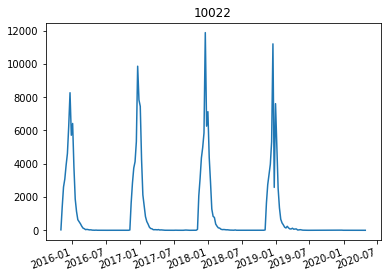

10022
6120    112634 xx DLN Brente Mandler 190g 24stk
Name: VarenrNavn, dtype: object


In [78]:
target_products_plot([10022])



In [64]:
enkeltvare=df_vare.loc[df_vare['Vare_Id']==9994] # Vil vite VarenrNavn
enkeltvare.head()

,Vare_Id,Gammeltvarenr,Eksternvaregruppekode,Eksternvaregruppe,DINformat_Produksjon,Vektenhet dpk,Slettemerket,MaterialgruppeEmballasjekode,MaterialgruppeEmballasje,Varegruppenr,...,MerkeGrpLeder,MerkeGrp2YS,MerkeGrp1YS,SistSolgtDato,SalgsenhType,EANnr fpk indikator,VarenrNavn,Varegruppeinndeling,And_Varegruppe,UnderKategori
6094,9994,112149,SOS-999-999,Ikke relev. for SOS,NaN,KG,NaN,PALL,Paller,ACN-NATNØ,...,DLN,DLN NAT.NØTTER,BG,03/01/2021 00:00:00,D-pak,NaN,112600 DLN Pistasj 60g 10stk,Følges opp av selger,DLN Produkter i nøttestativ,NØTTER


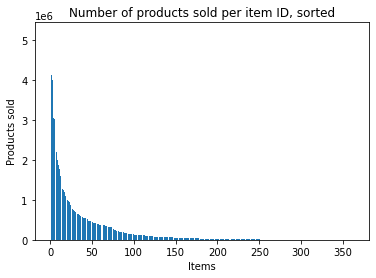

In [67]:

def df_split_into_top_mid_low_selling_products(df):
    df_topsalg=df.groupby(['Vare_Id']).agg({'Salg_sum':'sum'}).rename(columns={'Salg_sum':'Sales'})
    df_topsalg.sort_values(by='Sales', ascending=False,inplace=True)
    df_topsalg.reset_index(inplace=True)
    df_topsalg['Products']=df_topsalg.index
    plt.bar(df_topsalg.index, df_topsalg['Sales'])
    plt.ticklabel_format(useOffset=False)
    plt.xlabel('Items') 
    plt.ylabel('Products sold') 
    plt.title('Number of products sold per item ID, sorted')
    mid_number_of_rows=round(len(df_topsalg['Vare_Id'])/2)
    top_products=df_topsalg['Vare_Id'].head(180).to_list()
    mid_products=df_topsalg['Vare_Id'].iloc[65:75].to_list() # products with approx 50% sales volume of best sellers
    low_products=df_topsalg['Vare_Id'].iloc[140:150].to_list()  # products with approx 10% sales volume of best sellers
    return [top_products, mid_products, low_products]

#14418 should not be included as it lacks datapoints which HW does not accept(freq-term violation)
top10Products, mid10Products, low10Products = df_split_into_top_mid_low_selling_products(df)


